**Librerias necesarias para implementar el aprendizaje supervisado**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
import numpy as np
import os

### PARAMETROS MODIFICABLES

In [11]:
rutaArchivoDatos = (r"./recursos/1000gruposCluster.csv")
#el modelo y todos los archivos de salida se guardaran en el directorio ./modelos/
nombreModeloSalida = "forestRegressor.joblib"

### CARGAR LOS DATOS CLASIFICADOS

In [12]:
data = pd.read_csv(rutaArchivoDatos)

data_filtered = data.drop(['NumParadas', 'PorcentajePunto', 'Retraso', 'Cluster'], axis=1)
data_filtered

label_encoder_array = []
for col in data_filtered.columns:
    if data_filtered[col].dtype == 'object':
        label_encoder = LabelEncoder()
        data_filtered[col] = label_encoder.fit_transform(data[col])
        new_label_encoder = copy.deepcopy(label_encoder)
        label_encoder_array.append(new_label_encoder)

Division en training data y test data

In [13]:
X = data_filtered.drop('Puntuacion', axis=1)  # Ajusta 'target_column' al nombre de tu columna de destino
y = data_filtered['Puntuacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### REALIZAR SUPERVISION DE PARAMETROS PARA ENCONTRAR LOS MAS OPTIMOS
    tarda un tiempo

In [14]:
max_depth = 23
random_state = 11
print(f"Parametros defecto: max_depth={max_depth}, random_state={random_state}")
respuesta = input("Desea comprobar parametros mas optimos (>20 min)? (s/n)")

if respuesta.lower() == "s":
    scores = []
    for max_depth in range(1, 40):
        print(f"Probando bosque con depth={max_depth}")
        clf = RandomForestRegressor(max_depth=max_depth, verbose=0, n_jobs=4, criterion='squared_error')
        clf.fit(X_train, y_train)
        print(f"Score: {clf.score(X_test, y_test)}")
        scores.append(clf.score(X_test, y_test))
    plt.plot(range(1, 40), scores)
    plt.xlabel('Max Depth')
    plt.ylabel('Score')
    plt.show()
    max_depth = scores.index(max(scores)) + 1
    r2_scores = []
    for random_state in range(1,40):
        print(f"Probando bosque con random_state={random_state}")
        model = RandomForestRegressor(verbose=0, n_jobs=4, max_depth=max_depth, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
    plt.plot(range(1, 40), r2_scores)
    plt.xlabel('Random state')
    plt.ylabel('Score')
    plt.show()
    print("Mejor random state: ", r2_scores.index(max(r2_scores)))
    random_state = r2_scores.index(max(r2_scores)) + 1


Parametros defecto: max_depth=23, random_state=11


### ENTRENAMIENTO CON PARAMETROS OPTIMIZADOS

In [15]:
model = RandomForestRegressor(  n_estimators=190,
                                verbose=0, 
                                n_jobs=4, 
                                max_depth=max_depth, 
                                random_state=random_state, 
                                # min_samples_split=49
                            )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, n_estimators=190, n_jobs=4, random_state=11)

ESTADISTICAS DEL MODELO

                       Feature  Importance
3                      KmVacio    0.684671
2  CodigoInternoParadaDescarga    0.119764
0                  IDconductor    0.118429
1     CodigoInternoParadaCarga    0.077136


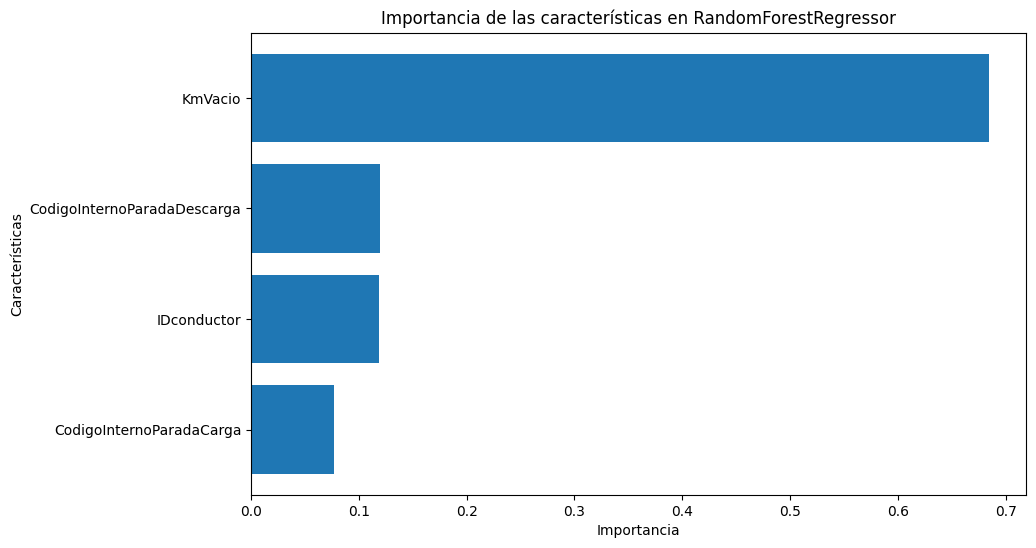

In [16]:
importancias = model.feature_importances_

# Crear un DataFrame para visualizar mejor la importancia
importancia_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importancias
})

# Ordenar el DataFrame por la importancia de las características en orden descendente
importancia_features = importancia_features.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print(importancia_features)

# Visualizar la importancia de las características utilizando un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importancia_features['Feature'], importancia_features['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características en RandomForestRegressor')
plt.gca().invert_yaxis()  # Para que las características más importantes aparezcan en la parte superior
plt.show()

In [17]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 5.642663428085715
Mean Squared Error (MSE): 79.27835676178795
R-squared (R2): 0.8912451635661713


### GUARDAR EL MODELO

In [18]:
import joblib
pathArchivoAGenerar = os.getcwd() + "/modelos/" + nombreModeloSalida
pathArchivoAGenerar

if(os.path.exists(pathArchivoAGenerar)):
    print("El archvivo " + pathArchivoAGenerar +" ya existe")
    # print("Quiere sobreescribir el archivo (s/n)")
    respuesta = input("Quiere sobreescribir el archivo (s/n)")
    # print(respuesta)
    if (respuesta == 's'):
        print("Sobreescribiendo el archivo" + pathArchivoAGenerar)
        joblib.dump(model, pathArchivoAGenerar) 
        joblib.dump(label_encoder_array, os.getcwd()+ "/modelos/" + "encoderArray.joblib")
        np.savetxt(os.getcwd() + "/modelos/" + "conductores.csv", data['IDconductor'].unique(), delimiter=',', fmt='%s')
        np.savetxt(os.getcwd() + "/modelos/" + "paradasCarga.csv", data['CodigoInternoParadaCarga'].unique(),  delimiter=',', fmt='%s')
        np.savetxt(os.getcwd() + "/modelos/" + "paradasDescarga.csv", data['CodigoInternoParadaDescarga'].unique(),  delimiter=',', fmt='%s')
else:
    print("Generando el archivo " + pathArchivoAGenerar)
    joblib.dump(model, pathArchivoAGenerar) 
    joblib.dump(label_encoder_array, os.getcwd()+ "/modelos/" + "encoderArray.joblib")
    np.savetxt(os.getcwd() + "/modelos/" + "conductores.csv", data['IDconductor'].unique(), delimiter=',', fmt='%s')
    np.savetxt(os.getcwd() + "/modelos/" + "paradasCarga.csv", data['CodigoInternoParadaCarga'].unique(),  delimiter=',', fmt='%s')
    np.savetxt(os.getcwd() + "/modelos/" + "paradasDescarga.csv", data['CodigoInternoParadaDescarga'].unique(),  delimiter=',', fmt='%s')
    print("El archivo " + pathArchivoAGenerar + " ha sido generado")

El archvivo c:\Users\pablo.gallardo\Desktop\final\codigo/modelos/forestRegressor.joblib ya existe


### **PRUEBA DEL MODELO CON TODOS LOS CONDUCTORES** distancias aleatorias

*se generan los km en vacio de cada conductor aleatoriamente entre 50 y 400*

In [19]:
conductores = data['IDconductor'].unique()
conductores.shape
import random
paradaCargaPrueba = "03"
paradaDescargaPrueba = "100576784"
lista_conductores_puntuacion = []
for conductor in conductores:
    km_vacio = random.randint(50, 400)
    to_pred = pd.DataFrame([{
        'IDconductor': conductor, 
        'CodigoInternoParadaCarga': paradaCargaPrueba,  
        'CodigoInternoParadaDescarga': paradaDescargaPrueba,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
        i+=1
    # print(to_pred)
    # print(to_pred['IDconductor'], "\n", to_pred['CodigoInternoParadaCarga'], "\n", to_pred['CodigoInternoParadaDescarga'])

    prediction = model.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction}
    lista_conductores_puntuacion.append(puntuacion_conductor)


print(lista_conductores_puntuacion)

conductores_ordenados = sorted(lista_conductores_puntuacion, key=lambda x: x["Prediccion"], reverse=True)

print("Mejores conductores:")
for conductor in conductores_ordenados[:5]:
    print(conductor)
    

[{'Conductor': 'Y4446672G', 'KmVacio': 156, 'Prediccion': array([60.765995])}, {'Conductor': '46401708J', 'KmVacio': 212, 'Prediccion': array([40.46773351])}, {'Conductor': '52069433D', 'KmVacio': 399, 'Prediccion': array([23.59325801])}, {'Conductor': 'X6557371W', 'KmVacio': 119, 'Prediccion': array([51.73758866])}, {'Conductor': 'Y7449758A', 'KmVacio': 362, 'Prediccion': array([24.95024667])}, {'Conductor': 'X5821319L', 'KmVacio': 84, 'Prediccion': array([65.46245961])}, {'Conductor': '39847805Y', 'KmVacio': 124, 'Prediccion': array([62.31790273])}, {'Conductor': 'X5480310P', 'KmVacio': 336, 'Prediccion': array([15.12533496])}, {'Conductor': '39856757B', 'KmVacio': 394, 'Prediccion': array([19.57867375])}, {'Conductor': '39940701M', 'KmVacio': 306, 'Prediccion': array([18.50436023])}, {'Conductor': 'X8875206N', 'KmVacio': 63, 'Prediccion': array([75.35635004])}, {'Conductor': '77832943T', 'KmVacio': 298, 'Prediccion': array([11.20332795])}, {'Conductor': '05900148G', 'KmVacio': 151, 

### **PRUEBA DEL MODELO CON UNICO CONDUCTOR Y DISTINTAS DISTANCIAS**

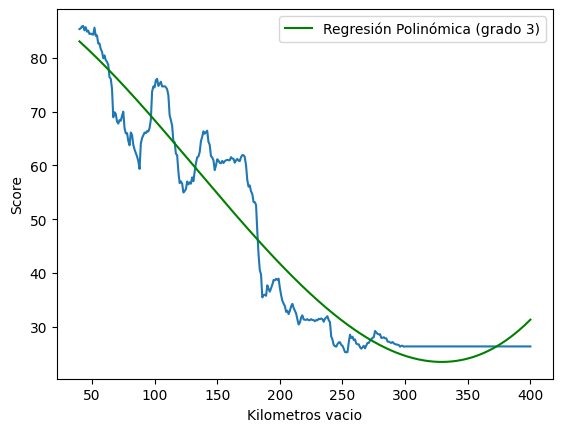

In [22]:
lista_conductorX_puntuaciones = []
conductor = "Y4446672G"
for km_vacio in range(40, 401, 20):
    to_pred = pd.DataFrame([{
        'IDconductor': conductor, 
        'CodigoInternoParadaCarga': "03",  
        'CodigoInternoParadaDescarga': "100576784",
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
        i+=1

    
    prediction = model.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction[0]}
    lista_conductorX_puntuaciones.append(puntuacion_conductor)
    

# for item in lista_conductorX_puntuaciones:
#     print(item)


# Extraer los valores de KmVacio y Prediccion
km_vacio = np.array([x["KmVacio"] for x in lista_conductorX_puntuaciones])
predicciones = np.array([x["Prediccion"] for x in lista_conductorX_puntuaciones])

# Ajustar una regresión polinómica (grado 2 en este caso)
grado = 3
coef = np.polyfit(km_vacio, predicciones, grado)
polinomio = np.poly1d(coef)

# Calcular los valores predichos usando el polinomio
y_pred2 = polinomio(km_vacio)

plt.plot(range(40, 401, 20), [x["Prediccion"] for x in lista_conductorX_puntuaciones])
# Graficar la curva de regresión polinómica
x_range = np.linspace(km_vacio.min(), km_vacio.max(), 500)
plt.plot(x_range, polinomio(x_range), color='green', label=f'Regresión Polinómica (grado {grado})')
plt.xlabel('Kilometros vacio')
plt.ylabel('Score')
plt.legend()
plt.show()

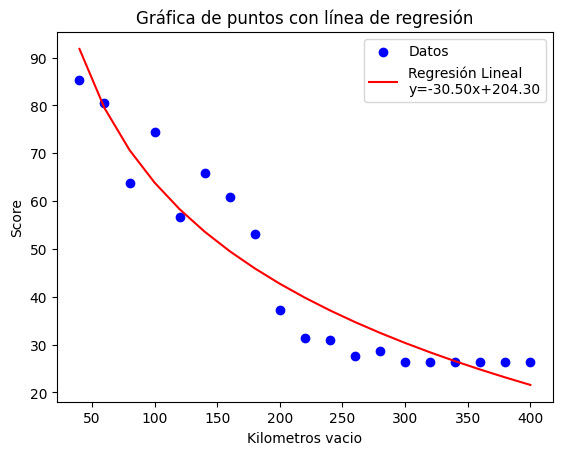

In [21]:
# Extraer los valores de KmVacio y Prediccion
km_vacio = np.array([x["KmVacio"] for x in lista_conductorX_puntuaciones])
predicciones = np.array([x["Prediccion"] for x in lista_conductorX_puntuaciones])

log_km_vacio = np.log(km_vacio)
# Ajustar una regresión (usaremos una regresión lineal en este caso)
coef = np.polyfit(log_km_vacio, predicciones, 1)  # 1 indica una regresión lineal
m = coef[0]  # Pendiente
b = coef[1]  # Ordenada al origen

# Calcular la línea de regresión
y_pred = m * log_km_vacio + b

# Graficar los puntos
plt.scatter(km_vacio, predicciones, color='blue', label='Datos')

# Graficar la línea de regresión
plt.plot(km_vacio, y_pred, color='red', label=f'Regresión Lineal\ny={m:.2f}x+{b:.2f}')

# Añadir títulos y etiquetas
plt.title('Gráfica de puntos con línea de regresión')
plt.xlabel('Kilometros vacio')
plt.ylabel('Score')
plt.legend()

# Mostrar la gráfica
plt.show()